In [1]:
from model import SirenImageLearner, SirenImageDataWrapper

import math
import torch
from torch.optim.lr_scheduler import CosineAnnealingLR
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import pytorch_lightning as pl

from torchvision.transforms import ToTensor, ToPILImage

from loguru import logger
import matplotlib.pyplot as plt
import PIL
import tqdm

# fuck it...
DEVICE = 'cuda'

In [2]:
!nvidia-smi

Tue Oct 12 15:01:28 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 471.41       Driver Version: 471.41       CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:01:00.0 Off |                  N/A |
|  0%   34C    P8     9W / 350W |    324MiB / 24576MiB |      1%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
im_path = '../data/google-photos-export/uncompressed/takeout-20210901T023707Z-001/Takeout/Google Photos/lithophane candidates/20210313_133327.jpg'
im = PIL.Image.open(im_path)
im3 = im.resize((122, 163)).convert('L').rotate(-90, expand=True)
t_im3 = ToTensor()(im3).squeeze()

from pytorch_lightning.loggers import TensorBoardLogger, MLFlowLogger, WandbLogger

#wandb_logger = WandbLogger()
tb_logger = TensorBoardLogger("tb_logs", name="siren-upsample")

model = SirenImageLearner(
    #notebook_mode=True
    warmup_steps=150,
    cvm_alpha=1,#00,
    )
dm = SirenImageDataWrapper(target_image=t_im3)


from pytorch_lightning.callbacks import LearningRateMonitor, StochasticWeightAveraging
lr_monitor = LearningRateMonitor(logging_interval='step')

# https://pytorch-lightning.readthedocs.io/en/latest/extensions/generated/pytorch_lightning.callbacks.StochasticWeightAveraging.html#pytorch_lightning.callbacks.StochasticWeightAveraging
# setting "Trainer(...,stochastic_weight_avg=True,...)" threw an error
# complaining that I didn't have max_epochs set. Probably another opportunity for a PR...
# also, the callback only has epoch-granularity settings. Nothing about steps.
swa_callback = StochasticWeightAveraging(
    swa_epoch_start  = 1500, # each step counts as an epoch?
    annealing_epochs = 300, # assuming this corresponds to Tmax for cosine annealing
    annealing_strategy= 'cos', # this is the default, just being explicit for my own benefit
)

# https://pytorch-lightning.readthedocs.io/en/latest/common/trainer.html#trainer-flags
trainer = pl.Trainer(
    gpus=-1,
    max_steps=5000,
    max_epochs=5000, # fuck it... must appease the SWA...
    #max_steps=100000, # I think there's a way to use CLI args to override here
    log_every_n_steps=100, #50,
    logger=tb_logger,
    log_gpu_memory=True, # fuck yeah!
    weights_summary=None,
    #stochastic_weight_avg=True, # neat I think this will do cosine annealing on its own?
    callbacks=[lr_monitor, swa_callback] # yeah baby.
)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


In [4]:
!nvidia-smi

Tue Oct 12 15:01:28 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 471.41       Driver Version: 471.41       CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:01:00.0 Off |                  N/A |
|  0%   34C    P8    10W / 350W |    324MiB / 24576MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [5]:
trainer.fit(model, dm)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Training: -1it [00:00, ?it/s]

C:\Users\shagg\anaconda3\envs\sandbox\lib\site-packages\pytorch_lightning\callbacks\stochastic_weight_avg.py:190: UserWarning: SWA is currently only supported every epoch. Found {'scheduler': <torch.optim.lr_scheduler.CosineAnnealingLR object at 0x0000017167935250>, 'name': None, 'interval': 'step', 'frequency': 1, 'reduce_on_plateau': False, 'monitor': None, 'strict': True, 'opt_idx': None}
  rank_zero_warn(f"SWA is currently only supported every epoch. Found {scheduler_cfg}")
Swapping scheduler <torch.optim.lr_scheduler.CosineAnnealingLR object at 0x0000017167935250> for <torch.optim.swa_utils.SWALR object at 0x0000017217A7F1F0>


In [6]:
!nvidia-smi
# how do I delete data from the GPU when I'm done with it?

Tue Oct 12 15:09:17 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 471.41       Driver Version: 471.41       CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:01:00.0 Off |                  N/A |
|  0%   58C    P2   128W / 350W |   1454MiB / 24576MiB |     28%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [7]:
torch.cuda.empty_cache()

In [8]:
# To do: experiment with regularization

# To do: WandB logging?

# To do: hparams parallel coords? wandb have this already? 
# Maybe easier with MLFlow logging to local db serving a custom dashboard

In [9]:
#model.to('cuda') # if the model is already on this device, does this duplicate the data?

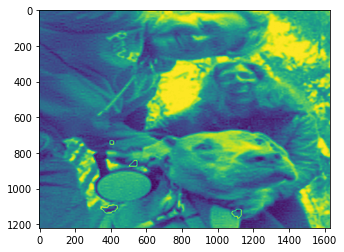

In [10]:
DEVICE = 'cpu'

def make_idx_from_shape(shape):
    x,y = shape
    idx = []
    for i in range(x):
        for j in range(y):
            idx.append((i,j))
    idx = torch.tensor(idx, device=DEVICE)
    return {'coords':idx, 'coords_rescaled':rescale_coords(idx, shape)}

def rescale_coords(coords, shape):
    scale = torch.tensor(shape, device=DEVICE)
    b = (coords / scale)
    b = (b-.5)/.5
    return b

with torch.no_grad():
    model.eval()
    idx0 = model._idx0
    x,y = tuple(idx0.max(dim=0).values+1)
    sr_k=10 #10 # go big or go home?
    #U = torch.rand(x*y,2, device=DEVICE)
    #sampled_coords = (U-.5)/.5
    shape_resolve = (sr_k*x, sr_k*y)
    idx_resolve = make_idx_from_shape(shape_resolve)
    y_resolve = model.forward(idx_resolve['coords_rescaled']).squeeze()
    im_resolve = model.build_image_from_coords(y_resolve, coords=idx_resolve['coords'])
    
    plt.imshow(im_resolve.detach().squeeze().cpu().numpy())
    plt.show()


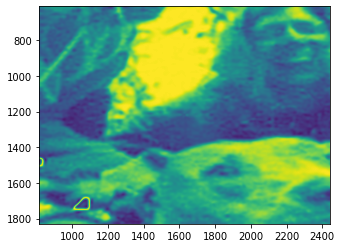

In [22]:
# let's see what happens if we just zoom in on a chunk
with torch.no_grad():
    idx0 = model._idx0
    x,y = tuple(idx0.max(dim=0).values+1)
    sr_k=20 #10 # go big or go home?
    #U = torch.rand(x*y,2, device=DEVICE)
    #sampled_coords = (U-.5)/.5
    shape_resolve = (sr_k*x, sr_k*y)
    idx_resolve = make_idx_from_shape(shape_resolve)
    coords_rescaled0 = idx_resolve['coords_rescaled']
    mask_left = coords_rescaled0[:,0] > -0.5
    mask_right = coords_rescaled0[:,0] < 0.5
    mask_top = coords_rescaled0[:,1] < 0.5
    mask_bottom= coords_rescaled0[:,1] > -0.5
    zoom_mask = mask_left & mask_right & mask_top & mask_bottom
    coords_zoom_rescaled = coords_rescaled0[zoom_mask,: ]
    coords_zoom = idx_resolve['coords'][zoom_mask,: ]
    y_resolve = model.forward(coords_zoom_rescaled).squeeze()
    im_resolve = model.build_image_from_coords(y_resolve, coords=coords_zoom)
    
    plt.imshow(im_resolve.detach().squeeze().cpu().numpy())
    plt.xlim((coords_zoom[:,1].min(),coords_zoom[:,1].max()))
    plt.ylim((coords_zoom[:,0].max(),coords_zoom[:,0].min())) # upside down, sure why not
    plt.show()


In [12]:
# Quantile approximation for distributional similarity

import numpy as np

t_im3.shape # 122, 163
t_rand = torch.rand(t_im3.shape)
n_quantiles = 100

# I like the idea of taking random quantiles like this, but I think it complicates
# the integral approximation. If quantiles are evenly spaced, I can just sum. 
# otherwise, I think I need to factor in the dx
##q = torch.rand(n_quantiles).sort().values
#q = torch.linspace(0,1,steps=n_quantiles)

#p0 = t_im3.quantile(q).numpy()
#p1 = t_rand.quantile(q).numpy()
#q = q.numpy()
#d = np.abs(p0-p1)

def q_q_distance(t0, t1, n_quantiles=100):
    q = torch.linspace(0,1,steps=n_quantiles+1)[:-1]
    p0 = t0.quantile(q)
    p1 = t1.quantile(q)
    d = math.sum(math.abs(p0-p1))
    return d

In [13]:
#plt.scatter(q, p0)
#plt.scatter(q, p1)
#plt.show()


#plt.scatter(q, d)
#plt.show()

In [14]:
#d.sum()

In [15]:
 # not identical
#p0[0], p1[0], p0[-1], p1[-1] # ends up being the max, basically identical

In [16]:
# https://discuss.pytorch.org/t/torch-equivalent-of-numpy-random-choice/16146/19
def perm_gpu_f32(pop_size, num_samples):
    """Use torch.randperm to generate indices on a 32-bit GPU tensor."""
    return torch.randperm(pop_size, dtype=torch.int32, device='cuda')[:num_samples]


In [17]:
perm_gpu_f32(10,20) # this is specifically w/o replacement

tensor([7, 1, 4, 9, 5, 6, 0, 2, 8, 3], device='cuda:0', dtype=torch.int32)

In [18]:
#(x-.5)/.5 # shift then scale
#2x -1 # scale then shift

In [19]:
# helpful!
# https://www.kaggle.com/isbhargav/guide-to-pytorch-learning-rate-scheduling

#model = torch.nn.Linear(2, 1)
#optimizer = torch.optim.SGD(model.parameters(), lr=1) # does lr here event matter? I think it just needs to be anything
#scheduler = torch.optim.lr_scheduler.CyclicLR(
#    optimizer, 
#    base_lr=0.001,
#    max_lr=0.1,  #ultimately, this is what controls lr
#    step_size_up=5,
#    step_size_down=200,
#    mode="exp_range",
#    gamma=.996)
#lrs = []


#for i in range(1000):
#    optimizer.step()
#    lrs.append(optimizer.param_groups[0]["lr"])
##     print("Factor = ",i," , Learning Rate = ",optimizer.param_groups[0]["lr"])
#    scheduler.step()

#plt.plot(lrs)
#plt.show()